In [116]:
import sys, os

import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.inspection import permutation_importance

## Loading Dataset

In [2]:
df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v1_processed.csv", index_col=0)

In [3]:
df["Date"] = pd.to_datetime(df["Date"])

# Labels 3 days ahead
df["label_3days"] = df["label"].shift(-3)

# Labels 5 days ahead
df["label_5days"] = df["label"].shift(-5)

In [4]:
# Drop NA
df = df.dropna(axis = 0)
df = df.reset_index(drop=True)
df.head()

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label_3days,label_5days
0,2013-02-15,1.3363,1.3363,1.3394,1.3306,0.01%,0.0002,0.0,1.344735,1.336730,...,0.002701,0.005461,-0.002760,-0.000150,39.939646,1.364281,1.325189,-62.849696,1.0,0.0
1,2013-02-18,1.3352,1.3357,1.3377,1.3321,-0.08%,-0.0011,0.0,1.344925,1.335553,...,0.001906,0.004750,-0.002844,-0.004102,38.588551,1.363994,1.325856,-68.561252,1.0,1.0
2,2013-02-19,1.3388,1.3352,1.3397,1.3329,0.27%,0.0036,2.0,1.345260,1.338051,...,0.001549,0.004109,-0.002561,-0.004906,45.544851,1.363601,1.326919,-57.039491,0.0,0.0
3,2013-02-20,1.3281,1.3387,1.3434,1.3270,-0.80%,-0.0107,1.0,1.345075,1.330396,...,0.000398,0.003367,-0.002969,-0.012785,32.802173,1.364052,1.326098,-90.131403,1.0,2.0
4,2013-02-21,1.3189,1.3283,1.3291,1.3161,-0.69%,-0.0092,1.0,1.344140,1.321553,...,-0.001242,0.002445,-0.003688,-0.012873,25.675429,1.366251,1.322029,-149.263447,0.0,1.0


<AxesSubplot:xlabel='Price', ylabel='Count'>

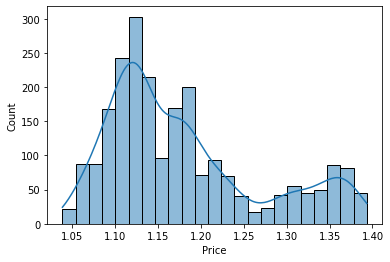

In [17]:
sns.histplot(df["Price"], kde=True)

## Window

In [57]:
time = ["Date"]

columns = [ "sma", "ema", "cma", "macd",	"macd_s",
"macd_h", "roc", "rsi",	"Bollinger_up", "Bollinger_down", "cci"]

labels = ["label", "label_3days", "label_5days"]

features1 = df[time + columns + labels]

features1.shape

(2311, 15)

In [58]:
features1.head()

,Date,sma,ema,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label,label_3days,label_5days
0,2013-02-15,1.344735,1.336730,1.335315,0.002701,0.005461,-0.002760,-0.000150,39.939646,1.364281,1.325189,-62.849696,0.0,1.0,0.0
1,2013-02-18,1.344925,1.335553,1.335311,0.001906,0.004750,-0.002844,-0.004102,38.588551,1.363994,1.325856,-68.561252,0.0,1.0,1.0
2,2013-02-19,1.345260,1.338051,1.335408,0.001549,0.004109,-0.002561,-0.004906,45.544851,1.363601,1.326919,-57.039491,2.0,0.0,0.0
3,2013-02-20,1.345075,1.330396,1.335211,0.000398,0.003367,-0.002969,-0.012785,32.802173,1.364052,1.326098,-90.131403,1.0,1.0,2.0
4,2013-02-21,1.344140,1.321553,1.334782,-0.001242,0.002445,-0.003688,-0.012873,25.675429,1.366251,1.322029,-149.263447,1.0,0.0,1.0


In [59]:
# Standard Scaler
standard_scaler = StandardScaler()
standard_scaler.fit(features1.drop(time + labels, axis=1))
standard_scaler.mean_

array([ 1.17977209e+00,  1.17890886e+00,  1.23712365e+00, -6.15670090e-04,
       -5.98763832e-04, -1.69062585e-05, -3.13856743e-04,  4.87670189e+01,
        1.19763127e+00,  1.16191291e+00, -6.68399397e+00])

In [60]:
features2 = pd.DataFrame(standard_scaler.transform(features1.drop(time + labels, axis=1)), columns=columns)
features2 = pd.concat([features1[time], features2, features1[labels]], axis = 1)

In [61]:
features2.head()

,Date,sma,ema,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label,label_3days,label_5days
0,2013-02-15,1.843927,1.765630,1.700054,0.569493,1.104145,-1.562118,0.015643,-0.558306,1.868364,1.801523,-0.650418,0.0,1.0,0.0
1,2013-02-18,1.846050,1.752464,1.699997,0.433038,0.974598,-1.609756,-0.360889,-0.643759,1.865138,1.808891,-0.716559,0.0,1.0,1.0
2,2013-02-19,1.849795,1.780406,1.701675,0.371716,0.857946,-1.448553,-0.437408,-0.203793,1.860741,1.820610,-0.583134,2.0,0.0,0.0
3,2013-02-20,1.847727,1.694772,1.698255,0.174057,0.722679,-1.681263,-1.188020,-1.009730,1.865790,1.811559,-0.966349,1.0,1.0,2.0
4,2013-02-21,1.837276,1.595837,1.690823,-0.107617,0.554689,-2.090305,-1.196406,-1.460476,1.890450,1.766657,-1.651118,1.0,0.0,1.0


In [62]:
# Min Max Scaler
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(features1.drop(time + labels, axis=1))
print(minmax_scaler.min_) 
print(minmax_scaler.data_max_)

[-3.10524053 -2.9381228  -7.24653089  0.612275    0.61385758  0.49304603
  0.49677715 -0.07559624 -3.13797349 -2.94571986  0.48667009]
[1.38459500e+00 1.39303239e+00 1.34320512e+00 1.48608089e-02
 1.34700393e-02 6.40467385e-03 4.86418193e-02 9.08132109e+01
 1.39754232e+00 1.37748678e+00 2.26818881e+02]


In [65]:
features3 = pd.DataFrame(minmax_scaler.transform(features1.drop(time + labels, axis=1)), columns=columns)
features3 = pd.concat([features1[time], features3, features1[labels]], axis=1)

In [66]:
features3.head()

,Date,sma,ema,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label,label_3days,label_5days
0,2013-02-15,0.881818,0.840832,0.951557,0.682733,0.770395,0.274576,0.495229,0.397451,0.901518,0.850196,0.344430,0.0,1.0,0.0
1,2013-02-18,0.882381,0.837505,0.951537,0.662001,0.750015,0.267955,0.454337,0.381449,0.900666,0.852108,0.331504,0.0,1.0,1.0
2,2013-02-19,0.883374,0.844566,0.952132,0.652685,0.731663,0.290361,0.446026,0.463839,0.899504,0.855151,0.357580,2.0,0.0,0.0
3,2013-02-20,0.882826,0.822927,0.950919,0.622656,0.710383,0.258015,0.364508,0.312914,0.900838,0.852801,0.282687,1.0,1.0,2.0
4,2013-02-21,0.880053,0.797927,0.948284,0.579862,0.683956,0.201159,0.363597,0.228505,0.907350,0.841144,0.148861,1.0,0.0,1.0


In [155]:
# # Exporting scaled features
# features2.to_csv("../../data/processed/signalEUR_USD_Labelled_v1_standardscaled.csv")

# # Exporting min max features
# features3.to_csv("../../data/processed/signalEUR_USD_Labelled_v1_minmaxscaled.csv")

## Train test split

In [156]:
features = features3

In [157]:
X = features.drop(labels = time + labels, axis=1 )
y = features[["label"]]

print(X.shape)
print(y.shape)

(2311, 11)
(2311, 1)


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1848, 11) (463, 11)
(1848, 1) (463, 1)


## Training Decision Tree

In [159]:
tree_model1 = DecisionTreeClassifier(random_state=42)

tree_model1.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [160]:
tree_model1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [161]:
tree_model1_accuracy = tree_model1.score(X_test, y_test)

print(f"Accuracy: {tree_model1_accuracy:.5f}")

Accuracy: 0.50540


In [162]:
tree_model1.feature_importances_

array([0.02254464, 0.02857028, 0.08558593, 0.08126624, 0.05196517,
       0.11678272, 0.12457069, 0.24232853, 0.03841071, 0.03400347,
       0.17397162])

In [163]:
feature_impotance = permutation_importance(tree_model1, X_train, y_train)

In [164]:
feature_impt_results = pd.DataFrame({"Feature": X_train.columns, "Importances_mean": feature_impotance["importances_mean"],
"Importances_std": feature_impotance["importances_std"]})

# Sort in descending order
feature_impt_results = feature_impt_results.sort_values(by="Importances_mean", ascending=False, ignore_index=True)

feature_impt_results

,Feature,Importances_mean,Importances_std
0,rsi,0.641450,0.006260
1,cci,0.447078,0.005961
2,roc,0.244481,0.014121
3,macd_h,0.219589,0.003308
4,macd,0.192857,0.003221
5,cma,0.129545,0.006562
6,macd_s,0.065368,0.002725
7,Bollinger_down,0.063312,0.002346
8,Bollinger_up,0.055628,0.002306
9,ema,0.041126,0.001492


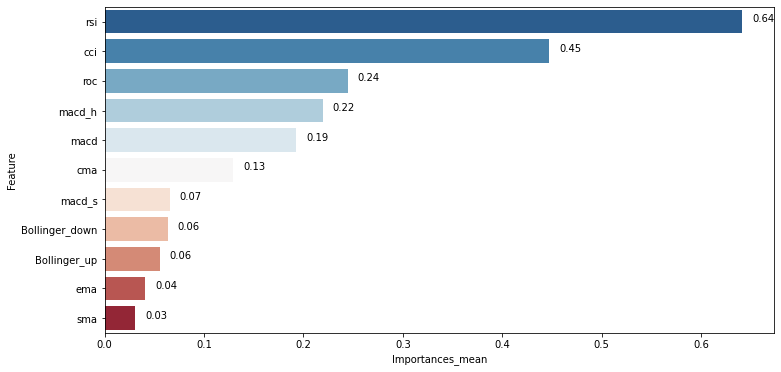

In [165]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.barplot(x="Importances_mean", y ="Feature", data=feature_impt_results, palette="RdBu_r")

# for i in ax.containers:
#     ax.bar_label(i)

for p in ax.patches:
    _x = p.get_x() + p.get_width() + float(0.01)
    _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
    value = '{:.2f}'.format(p.get_width())
    ax.text(_x, _y, value, ha="left")

plt.show()

## Training Random Forest

In [166]:
random_forest_model= RandomForestClassifier(random_state=42)

random_forest_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [167]:
random_forest_model.fit(X_train, y_train)

/Users/daniel/opt/anaconda3/envs/openbank1/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(random_state=42)

In [168]:
random_forest_model_accuracy = random_forest_model.score(X_test, y_test)

print(f"Accuracy: {random_forest_model_accuracy:.5f}")

Accuracy: 0.55940


In [169]:
random_forest_model.feature_importances_

array([0.05660855, 0.06089526, 0.0755308 , 0.08689046, 0.07601642,
       0.10172269, 0.11002155, 0.18251744, 0.06348193, 0.06349847,
       0.12281644])

In [170]:
feature_impotance = permutation_importance(random_forest_model, X_train, y_train)

In [171]:
feature_impt_results = pd.DataFrame({"Feature": X_train.columns, "Importances_mean": feature_impotance["importances_mean"],
"Importances_std": feature_impotance["importances_std"]})

# Sort in descending order
feature_impt_results = feature_impt_results.sort_values(by="Importances_mean", ascending=False, ignore_index=True)

feature_impt_results

,Feature,Importances_mean,Importances_std
0,rsi,0.558442,0.009410
1,cci,0.205736,0.006649
2,macd_h,0.144048,0.005184
3,roc,0.076623,0.004255
4,macd,0.052381,0.002065
5,cma,0.011688,0.002620
6,macd_s,0.005411,0.000342
7,Bollinger_up,0.002381,0.001004
8,Bollinger_down,0.002273,0.000631
9,ema,0.000325,0.000433


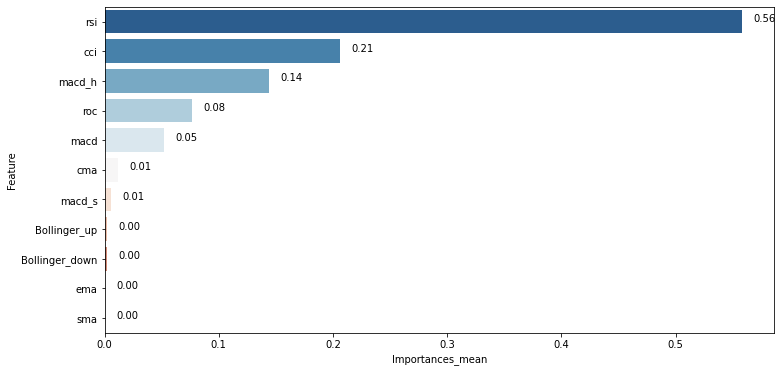

In [172]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.barplot(x="Importances_mean", y ="Feature", data=feature_impt_results, palette="RdBu_r")

# for i in ax.containers:
#     ax.bar_label(i)

for p in ax.patches:
    _x = p.get_x() + p.get_width() + float(0.01)
    _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
    value = '{:.2f}'.format(p.get_width())
    ax.text(_x, _y, value, ha="left")

plt.show()

## Training AdaBoost Classifier

In [173]:
adaboost_model = AdaBoostClassifier(random_state=42)

adaboost_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

In [174]:
adaboost_model.fit(X_train, y_train)

/Users/daniel/opt/anaconda3/envs/openbank1/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(random_state=42)

In [175]:
adaboost_model_accuracy = adaboost_model.score(X_test, y_test)

print(f"Accuracy: {adaboost_model_accuracy:.5f}")

Accuracy: 0.57019


In [176]:
adaboost_model.feature_importances_

array([0.  , 0.02, 0.04, 0.18, 0.02, 0.14, 0.06, 0.44, 0.  , 0.  , 0.1 ])

In [177]:
feature_impotance = permutation_importance(adaboost_model, X_train, y_train)

In [178]:
feature_impt_results = pd.DataFrame({"Feature": X_train.columns, "Importances_mean": feature_impotance["importances_mean"],
"Importances_std": feature_impotance["importances_std"]})

# Sort in descending order
feature_impt_results = feature_impt_results.sort_values(by="Importances_mean", ascending=False, ignore_index=True)

feature_impt_results

,Feature,Importances_mean,Importances_std
0,rsi,0.306169,0.007462
1,macd,0.113853,0.013089
2,macd_h,0.104221,0.005993
3,cci,0.057143,0.008981
4,roc,0.025649,0.000943
5,cma,0.018074,0.001830
6,ema,0.012013,0.001468
7,macd_s,0.009416,0.001114
8,sma,0.000000,0.000000
9,Bollinger_up,0.000000,0.000000


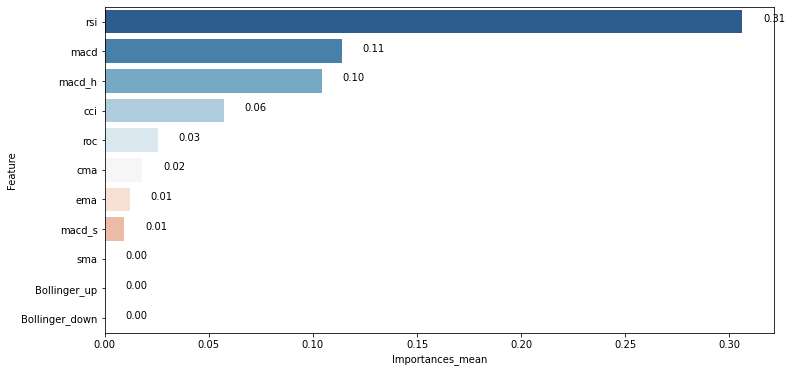

In [179]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.barplot(x="Importances_mean", y ="Feature", data=feature_impt_results, palette="RdBu_r")

# for i in ax.containers:
#     ax.bar_label(i)

for p in ax.patches:
    _x = p.get_x() + p.get_width() + float(0.01)
    _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
    value = '{:.2f}'.format(p.get_width())
    ax.text(_x, _y, value, ha="left")

plt.show()